In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import warnings
warnings.filterwarnings('ignore')

In [26]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
#VOLUME_SLICES = 100  
VOLUME_SLICES = 5 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [27]:
# TRAIN_DATASET_PATH = '/kaggle/input/brats2018/MICCAI_BraTS_2018_Data_Training/HGG/'
# VALIDATION_DATASET_PATH = '/kaggle/input/brats2018/MICCAI_BraTS_2018_Data_Validation/'

TRAIN_DATASET_PATH = 'brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'brats_2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'


In [28]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()

In [29]:
test_image_t2.shape

(240, 240, 155)

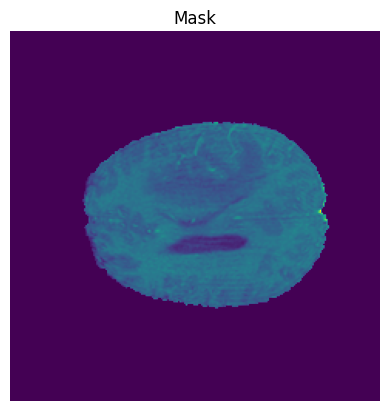

In [30]:
slice_w = 25
plt.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
plt.title('Mask')
plt.axis('off')
plt.savefig('Mask.png')

In [31]:
temp_combined_images = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
temp_combined_images.shape

(240, 240, 155, 3)

In [32]:
#temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]

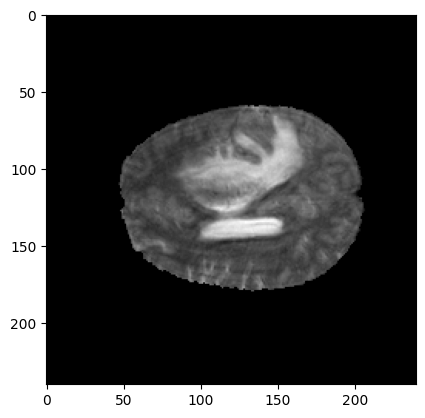

In [33]:
plt.imshow(temp_combined_images[:,:,test_image_t2.shape[0]//2-slice_w,2], cmap = 'gray')

In [ ]:
# import cv2 as cv
# import numpy as np

# img1 = cv.imread('./flair.png')
# img2 = cv.imread('./t1ce.png')
# img3 = cv.imread('./t2.png')

# bitwise_or = cv.bitwise_or(img1, img2)
# bitwise_or2 = cv.bitwise_or(bitwise_or, img3)

# bitwise_or2 = cv.cvtColor(bitwise_or2, cv.COLOR_BGR2RGB)
# bitwise_or2.shape

In [ ]:
# plt.imshow(bitwise_or2)

1
1
1


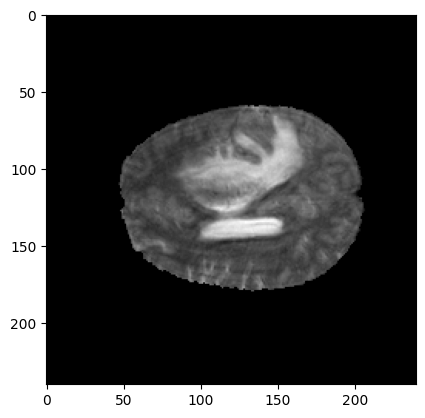

In [34]:
for i in range(3):
    plt.imshow(temp_combined_images[:,:,test_image_t2.shape[0]//2-slice_w,i], cmap = 'gray')
    print(1)

Text(0.5, 1.0, 'Mask')

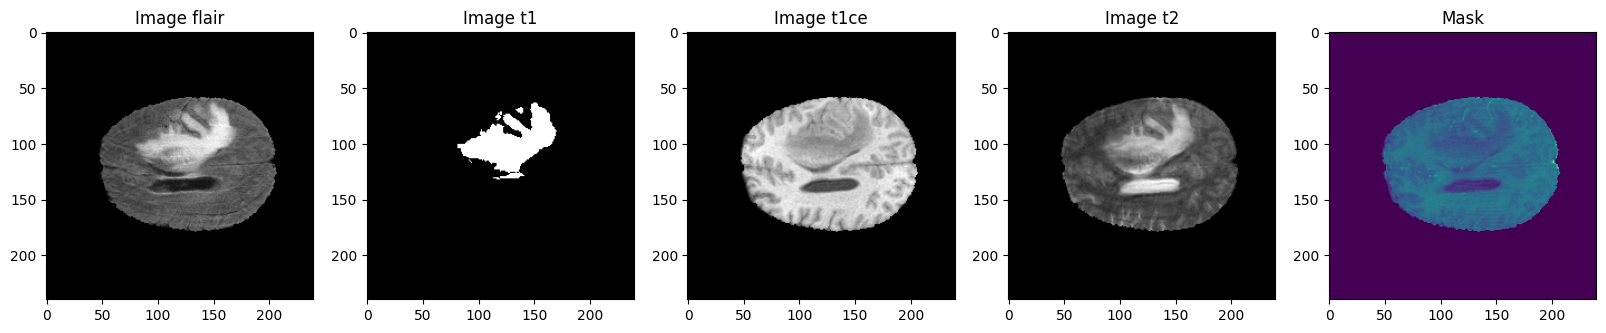

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

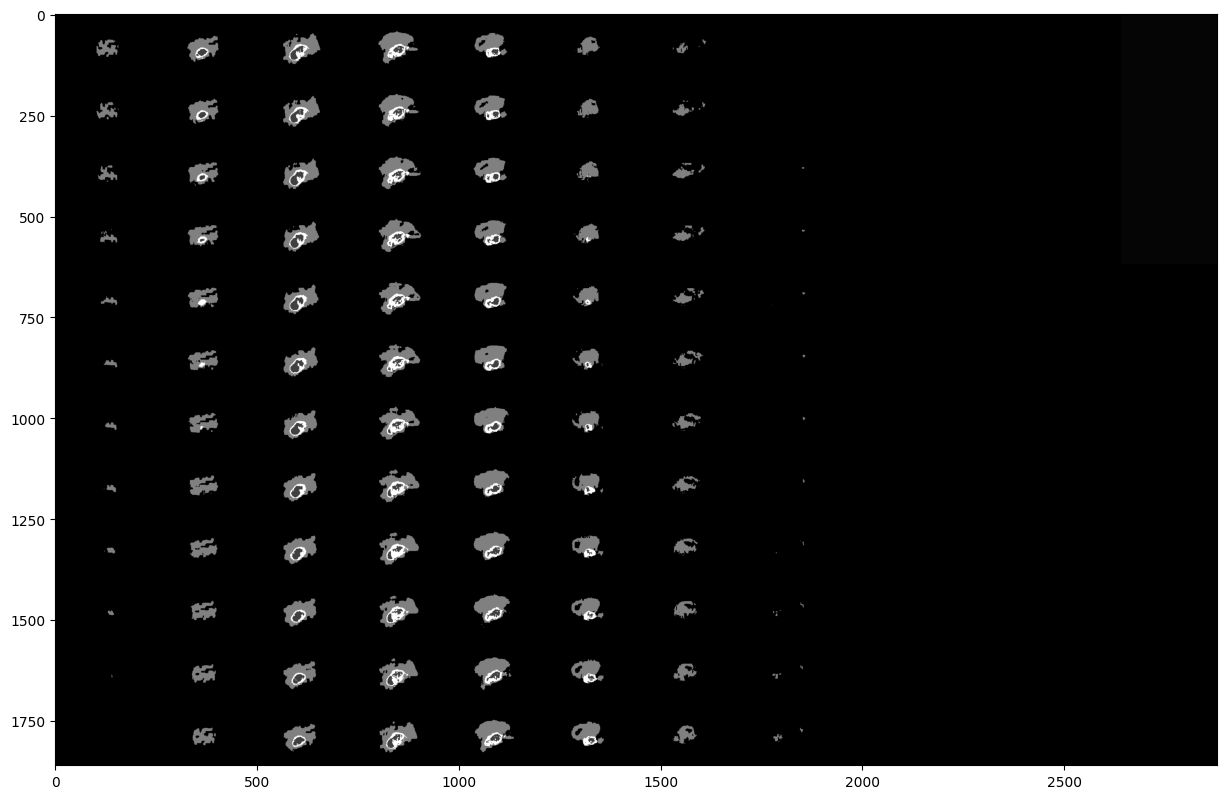

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

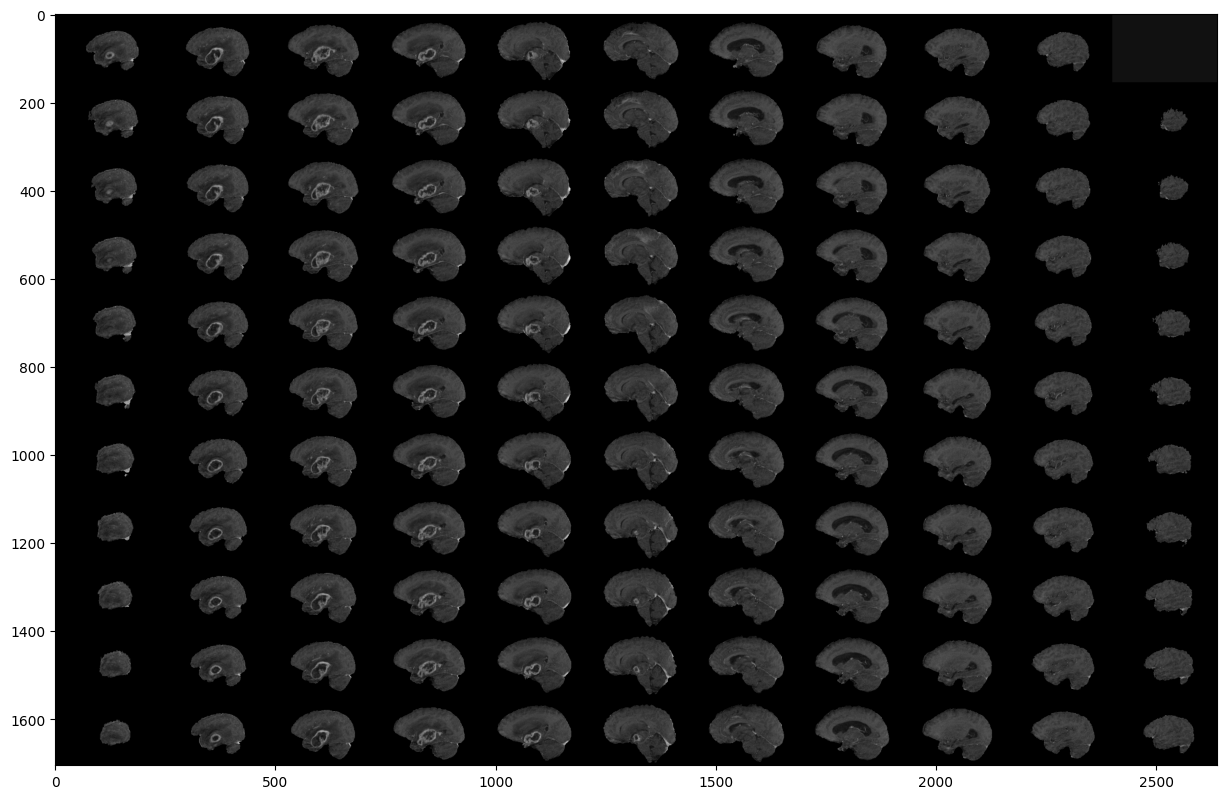

In [37]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

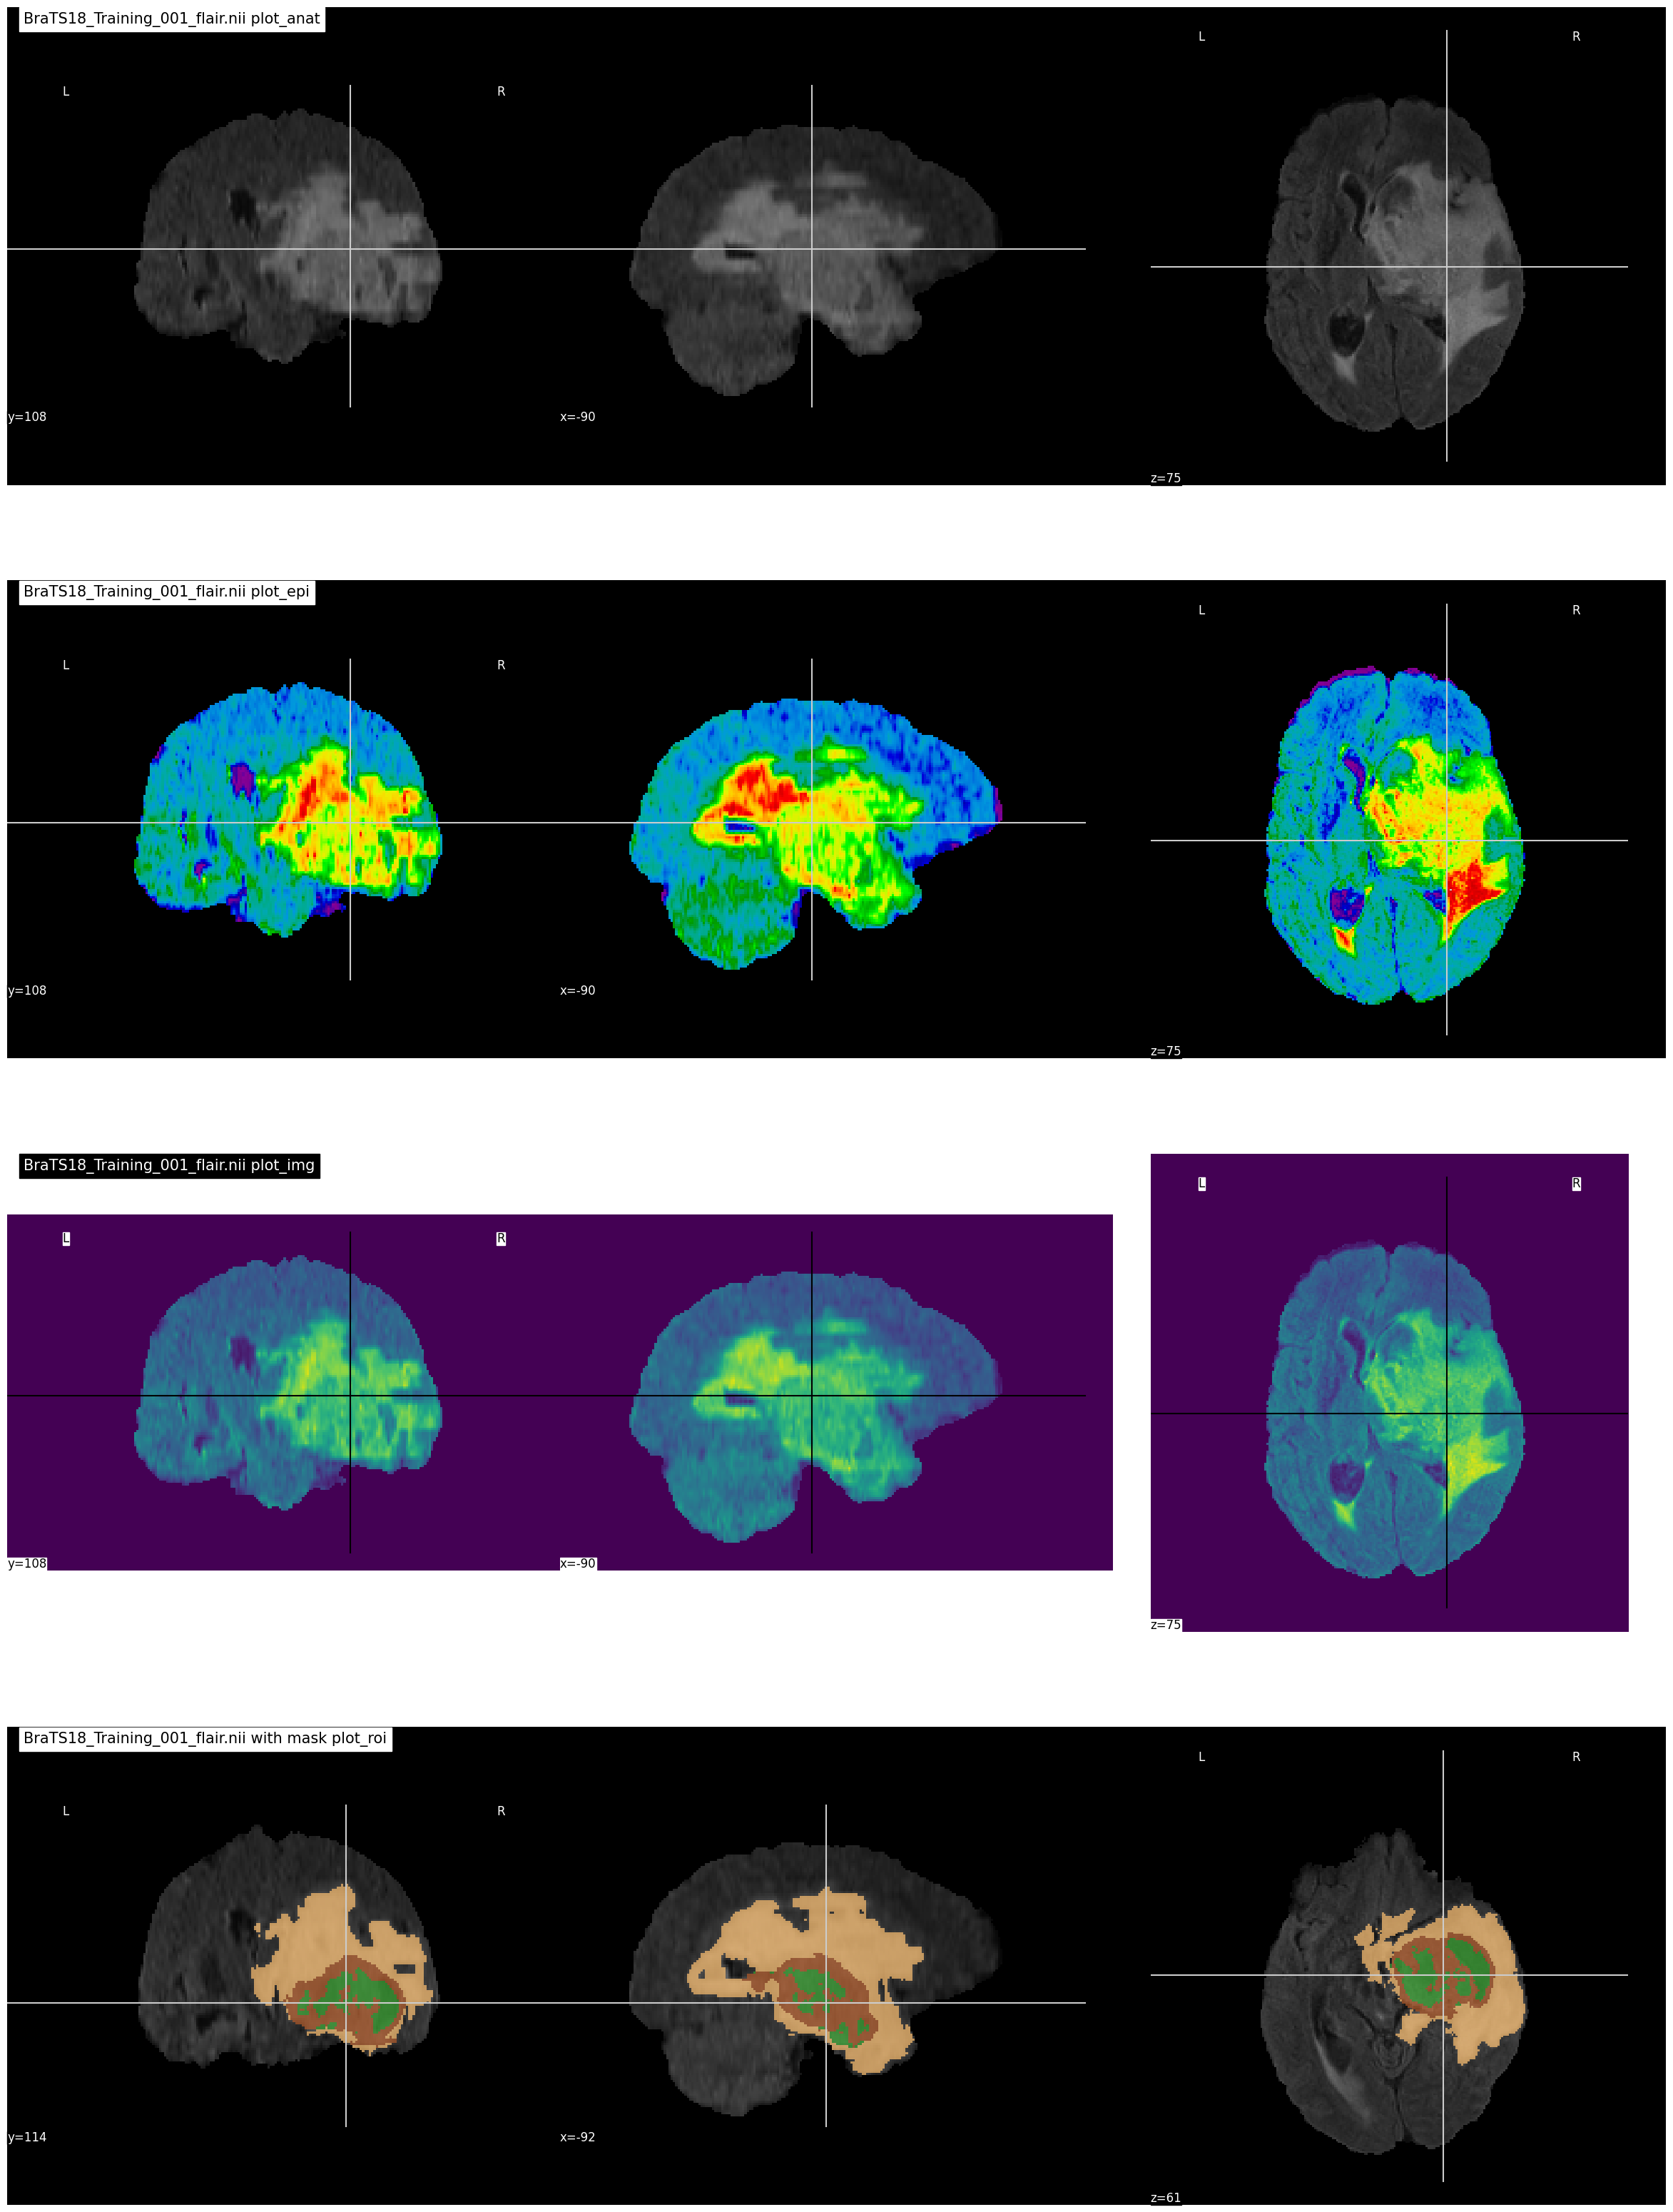

In [38]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS18_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS18_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS18_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS18_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()

In [39]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
            
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,1] * y_pred[:,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,2] * y_pred[:,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,3] * y_pred[:,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [40]:
def build_unet(inputs, ker_init):
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c9)
     
    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
model = build_unet(input_layer, 'he_normal')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


2024-03-09 19:00:02.436214: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 19:00:02.567776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 19:00:02.567845: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 19:00:02.570381: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-09 19:00:02.570466: I external/local_xla/xla/stream_executor

In [41]:
model.input_shape

(None, 128, 128, 128, 3)

In [42]:
model.output_shape

(None, 128, 128, 128, 4)

In [43]:
for layer in model.layers:
    print(layer.name, layer.output_shape)

input_1 [(None, 128, 128, 128, 3)]
conv3d (None, 128, 128, 128, 16)
dropout (None, 128, 128, 128, 16)
conv3d_1 (None, 128, 128, 128, 16)
max_pooling3d (None, 64, 64, 64, 16)
conv3d_2 (None, 64, 64, 64, 32)
dropout_1 (None, 64, 64, 64, 32)
conv3d_3 (None, 64, 64, 64, 32)
max_pooling3d_1 (None, 32, 32, 32, 32)
conv3d_4 (None, 32, 32, 32, 64)
dropout_2 (None, 32, 32, 32, 64)
conv3d_5 (None, 32, 32, 32, 64)
max_pooling3d_2 (None, 16, 16, 16, 64)
conv3d_6 (None, 16, 16, 16, 128)
dropout_3 (None, 16, 16, 16, 128)
conv3d_7 (None, 16, 16, 16, 128)
max_pooling3d_3 (None, 8, 8, 8, 128)
conv3d_8 (None, 8, 8, 8, 256)
dropout_4 (None, 8, 8, 8, 256)
conv3d_9 (None, 8, 8, 8, 256)
conv3d_transpose (None, 16, 16, 16, 128)
concatenate (None, 16, 16, 16, 256)
conv3d_10 (None, 16, 16, 16, 128)
dropout_5 (None, 16, 16, 16, 128)
conv3d_11 (None, 16, 16, 16, 128)
conv3d_transpose_1 (None, 32, 32, 32, 64)
concatenate_1 (None, 32, 32, 32, 128)
conv3d_12 (None, 32, 32, 32, 64)
dropout_6 (None, 32, 32, 32, 64)
c

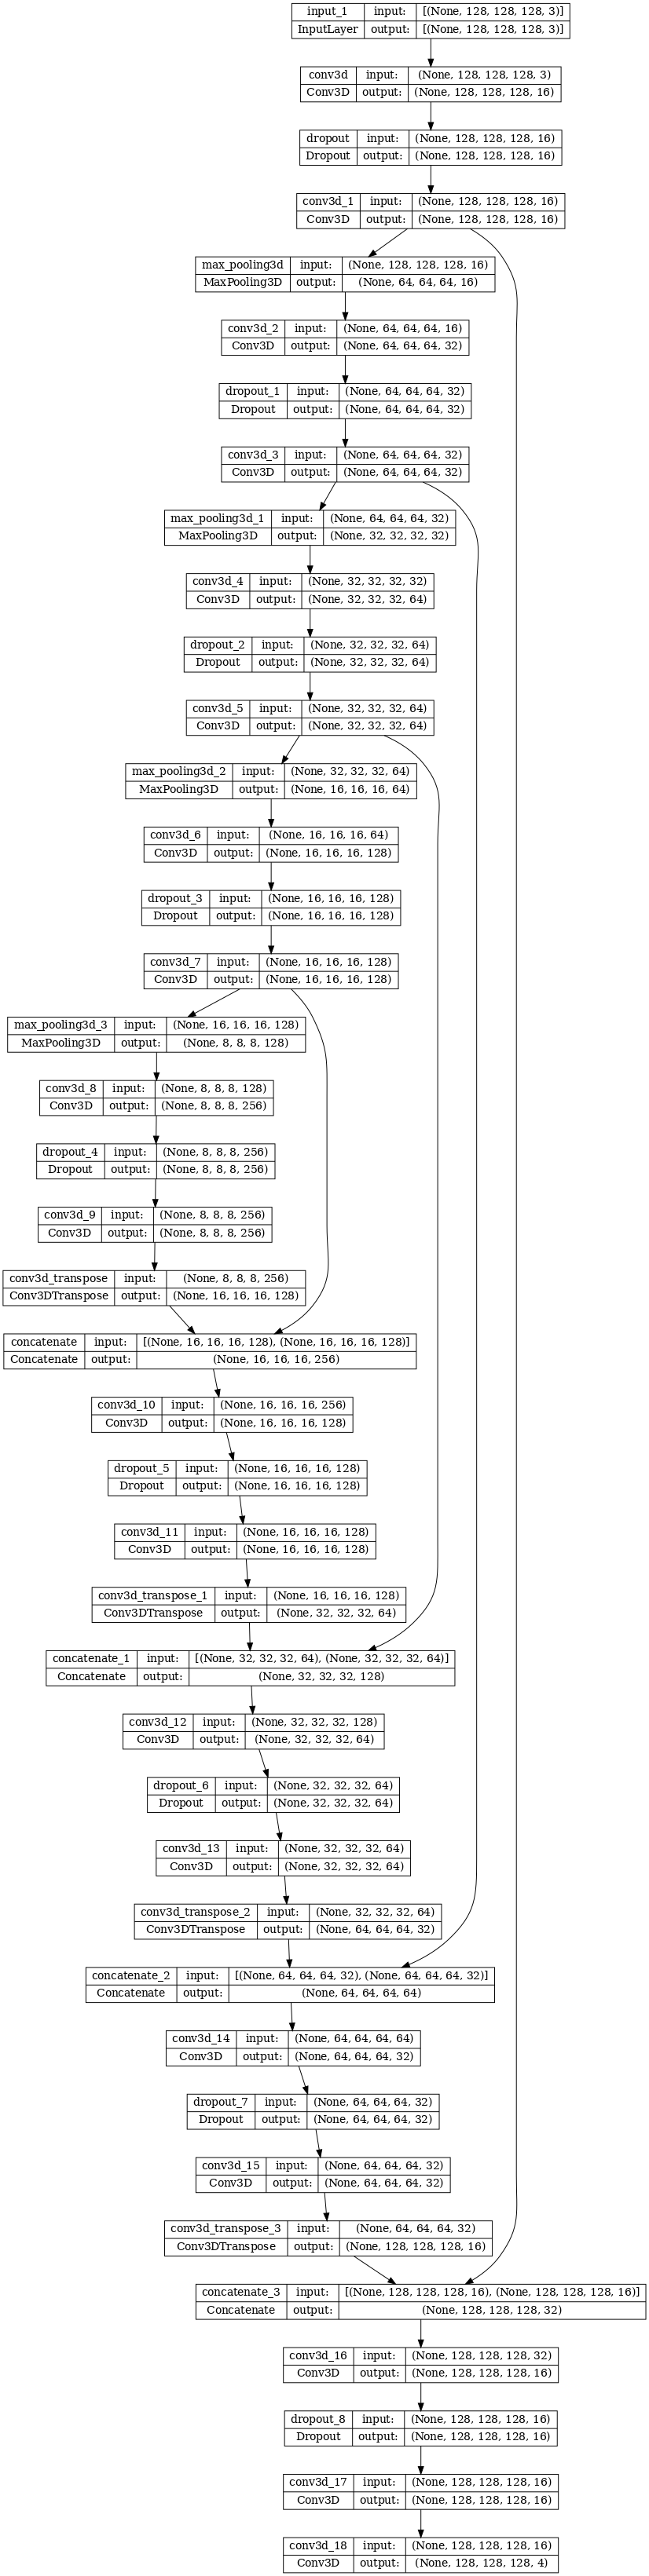

In [44]:
plot_model(model, 
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 70)

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 128, 3)]   0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 128, 128, 128, 16)    1312      ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 128, 16)    0         ['conv3d[0][0]']              
                                                                                                  
 conv3d_1 (Conv3D)           (None, 128, 128, 128, 16)    6928      ['dropout[0][0]']             
                                                                                              

In [46]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [47]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        #y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim))
        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t2.nii'); 
            t2 = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            #seg=seg.astype(np.uint8)
            #seg[seg==4] = 3

            #temp_combined_images = np.stack([flair, ce, t2], axis=3)
            #temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
            #temp_mask = seg[56:184, 56:184, 13:141]
            
            slice_w = 25

            for j in range(VOLUME_SLICES):
                X[j +VOLUME_SLICES*c,:,:,:,0] = cv2.resize(flair[:,:,flair.shape[0]//2-slice_w+j], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,:,1] = cv2.resize(ce[:,:,ce.shape[0]//2-slice_w+j], (IMG_SIZE, IMG_SIZE));
                X[j +VOLUME_SLICES*c,:,:,:,2] = cv2.resize(t2[:,:,t2.shape[0]//2-slice_w+j], (IMG_SIZE, IMG_SIZE));

                #y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                Y[j +VOLUME_SLICES*c,:,:,:] = cv2.resize(seg[:,:,seg.shape[0]//2-slice_w+j], (IMG_SIZE, IMG_SIZE));
                    
        # Generate masks
        #y[y==4] = 3;
        Y[Y==4] = 3;
        mask = tf.one_hot(Y, 4);
        #Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), mask
        #return temp_combined_images/np.max(temp_combined_images), temp_mask
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)

In [48]:
slice_w = 25
seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
Y = np.zeros((1, 128, 128, 128))
Y[0,:,:,:] = cv2.resize(seg[:,:,seg.shape[0]//2-slice_w], (128, 128));
print(Y.shape)
Y[Y==4] = 3;
mask = tf.one_hot(Y, 4);
mask.shape

(1, 128, 128, 128)


TensorShape([1, 128, 128, 128, 4])

In [49]:
X = np.zeros((1, 128, 128, 128, 3))
flair = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()  
ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()

X[0,:,:,:,0] = cv2.resize(flair[:,:,flair.shape[0]//2-slice_w], (128, 128));
X[0,:,:,:,1] = cv2.resize(ce[:,:,ce.shape[0]//2-slice_w], (128, 128));
X[0,:,:,:,2] = cv2.resize(t2[:,:,t2.shape[0]//2-slice_w], (128, 128));

X = X/np.max(X)

X.shape

(1, 128, 128, 128, 3)

In [50]:
print(len(train_ids))
print(len(val_ids))
print(len(test_ids))

250
74
45


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


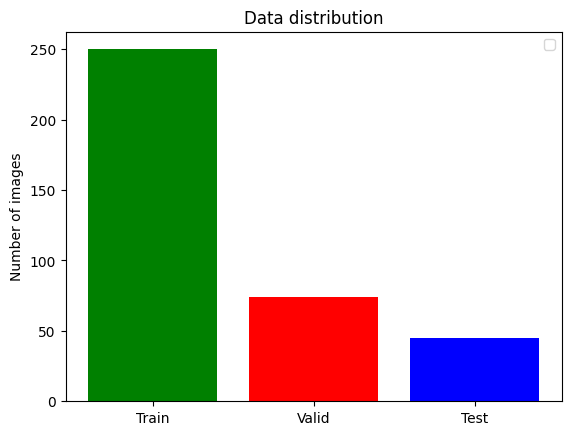

In [51]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')
    plt.savefig('data2018.png')
    plt.show()
    
showDataLayout()

In [52]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath="3D-UNet-2018-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5" 

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stop = EarlyStopping(monitor='val_loss',min_delta=0.001, patience=10, verbose=1, restore_best_weights=True)

csv_logger = CSVLogger('training_2018_3D_UNet.log')

history =  model.fit(training_generator,
                    epochs=100,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger, early_stop],
                    validation_data = valid_generator
                    )  

Epoch 1/100


2024-03-09 19:00:09.586032: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-09 19:00:09.662214: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-09 19:00:10.077720: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-09 19:00:33.391767: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.80GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-09 19:00:33.896479: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.80GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance 

NotFoundError: Graph execution error:

Detected at node model/conv3d_18/Conv3D defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/tensor/miniconda3/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/tensor/miniconda3/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/tensor/miniconda3/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_689/2812413244.py", line 11, in <module>

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

Detected at node model/conv3d_18/Conv3D defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/tensor/miniconda3/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/home/tensor/miniconda3/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/home/tensor/miniconda3/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 542, in dispatch_queue

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 531, in process_one

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 775, in execute_request

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipykernel_689/2812413244.py", line 11, in <module>

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/home/tensor/miniconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

2 root error(s) found.
  (0) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng53{k2=6,k13=0,k14=1,k18=0,k23=1}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 855638288 bytes.
	 [[{{node model/conv3d_18/Conv3D}}]]
	 [[confusion_matrix/assert_less/Assert/AssertGuard/pivot_f/_21/_53]]
  (1) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng53{k2=6,k13=0,k14=1,k18=0,k23=1}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 855638288 bytes.
	 [[{{node model/conv3d_18/Conv3D}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_6733]

In [ ]:
history =  model.fit(training_generator,
                    epochs=100,
                    steps_per_epoch=len(train_ids),
                    callbacks= [checkpoint, csv_logger],
                    validation_data = valid_generator
                    )

In [ ]:
model.save("model_2018_3D_UNet.h5")

In [ ]:
pwd

In [ ]:
X = np.zeros((1, 128, 128, 128, 3))
flair = nib.load(TRAIN_DATASET_PATH + 'Brats18_2013_2_1/Brats18_2013_2_1_flair.nii').get_fdata()  
ce = nib.load(TRAIN_DATASET_PATH + 'Brats18_2013_2_1/Brats18_2013_2_1_t1ce.nii').get_fdata()
t2 = nib.load(TRAIN_DATASET_PATH + 'Brats18_2013_2_1/Brats18_2013_2_1_t2.nii').get_fdata()

X[0,:,:,:,0] = cv2.resize(flair[:,:,flair.shape[0]//2-slice_w], (128, 128));
X[0,:,:,:,1] = cv2.resize(ce[:,:,ce.shape[0]//2-slice_w], (128, 128));
X[0,:,:,:,2] = cv2.resize(t2[:,:,t2.shape[0]//2-slice_w], (128, 128));

#X = X/np.max(X)

X.shape

In [ ]:
slice_w = 25
plt.imshow(X[0,:,:,test_image_t2.shape[0]//2-slice_w,2], cmap = 'gray')
plt.title('Image t2')
plt.axis('off')
#plt.savefig('t2.png')

In [ ]:
X.max()

In [ ]:
pred = model.predict(X)

In [ ]:
type(pred)

In [ ]:
pred.max()

In [ ]:
pred_3 = tf.argmax(pred, axis=4)
pred_3.shape

In [ ]:
pred_3 = np.asarray(pred_3)

In [ ]:
seg = nib.load(TRAIN_DATASET_PATH + 'Brats18_2013_2_1/Brats18_2013_2_1_seg.nii').get_fdata()
Y = np.zeros((1, 128, 128, 128))
Y[0,:,:,:] = cv2.resize(seg[:,:,seg.shape[0]//2-25], (128, 128));
#print(Y.shape)
Y[Y==4] = 3;
mask1 = tf.one_hot(Y, 4);
mask1.shape

In [ ]:
seg = nib.load(TRAIN_DATASET_PATH + 'Brats18_2013_2_1/Brats18_2013_2_1_seg.nii').get_fdata()
Y = np.zeros((128, 128, 128))
Y[:,:,:] = cv2.resize(seg[:,:,seg.shape[0]//2-25], (128, 128));


In [ ]:
seg.shape

In [ ]:
Y.max()

In [ ]:
pred_2 = np.asarray(pred_2)
pred_2.min()

In [ ]:
def display(im3d, cmap="gray", step=2):
    _, axes = plt.subplots(nrows=5, ncols=6, figsize=(16, 14))

    vmin = im3d.min()
    vmax = im3d.max()

    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        ax.set_xticks([])
        ax.set_yticks([])


display(pred_3[0])

In [ ]:
############ load trained model ################
model = tf.keras.models.load_model('model_2018_3D_UNet.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training_2018_3D_UNet.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()
plt.savefig('training_result_2018.png')
plt.show()

In [ ]:
csv_logger = CSVLogger('./evaluation_2018_3D_UNet.log')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= [csv_logger])
print("test loss, test acc:", results)

In [ ]:
# mri type must one of 1) flair 2) t1 3) t1ce 4) t2 ------- or even 5) seg
# returns volume of specified study at `path`
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
    Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim))
    for j in range(VOLUME_SLICES):
        X[j +VOLUME_SLICES*c,:,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j +VOLUME_SLICES*c,:,:,:,2] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

        Y[j +VOLUME_SLICES*c,:,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
    return np.array(image)


# load nifti file at `path`
# and load each slice with mask from volume
# choose the mri type & resize to `IMG_SIZE`
def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] ) 
        # for each slice in 3D volume, find also it's mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = cv2.resize(currentScanVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            mask_img = cv2.resize(currentMaskVolume[:,:,j], dsize=(IMG_SIZE,IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')
        
#brains_list_test, masks_list_test = loadDataFromDir(VALIDATION_DATASET_PATH, test_directories, "flair", 5)

In [ ]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
  #  y = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE))

   # /content/MICCAI_BraTS_2018_Data_Training/HGG/Brats18_2013_10_1/Brats18_2013_10_1_flair.nii

    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    vol_path = case_path + case + '_flair.nii';
    flair=nib.load(vol_path).get_fdata()
    
    #vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    vol_path = case_path + case + '_t1ce.nii';
    ce=nib.load(vol_path).get_fdata() 
    
    vol_path = case_path + case + '_t2.nii';
    t2=nib.load(vol_path).get_fdata() 
    
 #   vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii');
 #   seg=nib.load(vol_path).get_fdata()  

    
    for j in range(VOLUME_SLICES):
        X[j,:,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j,:,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
        X[j,:,:,:,2] = cv2.resize(t2[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
 #       y[j,:,:] = cv2.resize(seg[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
  #  model.evaluate(x=X,y=y[:,:,:,0], callbacks= callbacks)
    return model.predict(X/np.max(X), verbose=1)

In [ ]:
def showPredictsById(case, start_slice = 4):
    path = TRAIN_DATASET_PATH + case + '/'

    # TRAIN_DATASET_PATH + test_ids[0] + "/" + test_ids[0] + '_flair.nii'

    gt = nib.load(path + case +'_seg.nii').get_fdata()
    origImage = nib.load(path + case +'_flair.nii').get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt=cv2.resize(gt[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3) # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice,:,:,0,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.savefig('Test_01.png')
    plt.show()
    
    
showPredictsById(case=test_ids[0])
showPredictsById(case=test_ids[1])
showPredictsById(case=test_ids[2])
showPredictsById(case=test_ids[3])
showPredictsById(case=test_ids[4])
showPredictsById(case=test_ids[5])
showPredictsById(case=test_ids[6])